In [5]:
!pip install matplotlib seaborn

In [1]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
import torchtext
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [4]:
from Config import Config
from utils import *
from model import BERT
config = Config()


[-] Training Dataset: std_data/Race/middle/train.csv


In [5]:
# # Parameters
source_folder = '/content/drive/MyDrive/PolyU Master/NLP/EmotionClassifier/data'
destination_folder = '/content/drive/MyDrive/PolyU Master/NLP/EmotionClassifier/Model'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
# Model parameter
MAX_SEQ_LEN = config.MAX_SEQ_LEN
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)



# TabularDataset
train, valid = prepare_data()


Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

In [ ]:
best_model = BERT().to(device)
load_checkpoint(destination_folder + '/model.pt', best_model)

In [19]:
model = best_model
test_loader = test_iter
#Evaluate
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
        for ( labels, A,B,C,D), _ in valid_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)

            model_input = torch.stack([A,B,C,D],1)
            model_input = model_input.type(torch.LongTensor).to(device)

            output = model(model_input, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [44]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()

le.classes_ = numpy.load('/content/drive/MyDrive/PolyU Master/NLP/EmotionClassifier/le.npy',allow_pickle=True)
le.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [46]:
print('Classification Report:')
print(classification_report(le.inverse_transform(y_true), le.inverse_transform(y_pred), labels=le.classes_))

Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.94      0.90      1949
        fear       0.83      0.89      0.86      1747
         joy       0.91      0.91      0.91      4832
        love       0.77      0.74      0.76      1182
     sadness       0.94      0.91      0.93      4179
    surprise       0.81      0.70      0.75       511

    accuracy                           0.89     14400
   macro avg       0.86      0.85      0.85     14400
weighted avg       0.89      0.89      0.89     14400



[Text(0, 0.5, 'anger'),
 Text(0, 1.5, 'fear'),
 Text(0, 2.5, 'joy'),
 Text(0, 3.5, 'love'),
 Text(0, 4.5, 'sadness'),
 Text(0, 5.5, 'surprise')]

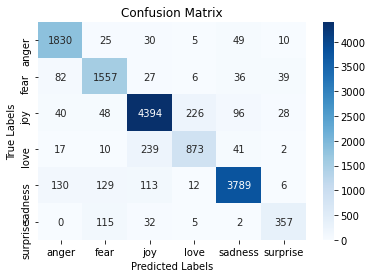

In [49]:
cm = confusion_matrix(le.inverse_transform(y_true), le.inverse_transform(y_pred), labels=le.classes_)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)